In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
from utiles import * 
df = pd.read_csv('ARP_Returns.csv')
df_norm, df_return = cal_return(df)

In [2]:
df_return.columns

Index(['Date', 'equity_momentum', 'equity_low_beta', 'equity_quality',
       'commodity_carry', 'commodity_curve', 'credit_curve', 'credit_carry',
       'fx_carry', 'fx_value', 'interest_rate_spread', 'interest_rate_curve',
       'equity_trend', 'fx_trend', 'commodity_trend', 'interest_rate_trend',
       'commodity_volatility_carry', 'interest_rate_volatility_carry',
       'equity_volatility_carry', 'cot', 'merger_arb'],
      dtype='object')

('2009-01-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2015-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2017-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
CPU times: user 55.9 s, sys: 448 ms, total: 56.3 s
Wall time: 22.6 s


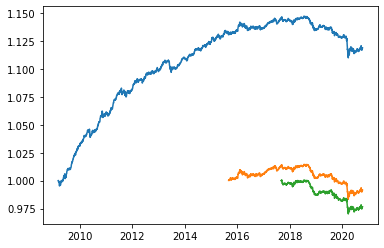

In [16]:
%%time
settings = [
            ('2009-01-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'), 
            ('2015-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'),
            ('2017-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
           ]

result = {} 

for i, config in enumerate(settings):
    print(config)
    result[i] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            lower_bound=config[2],
                                            drop_strategy=config[3],
                                            target=config[4])

In [17]:
print(result[0]['weights'].max() - 0.02, result[0]['weights'].max() + 0.02)

0.08 0.12000000000000001


In [18]:
print(result[1]['weights'].max() - 0.02, result[1]['weights'].max() + 0.02) 

0.08 0.12000000000000001


In [19]:
print(result[2]['weights'].max() - 0.02, result[2]['weights'].max() + 0.02) 

0.08 0.12000000000000001


('2009-01-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')
('2015-09-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')
('2017-09-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')


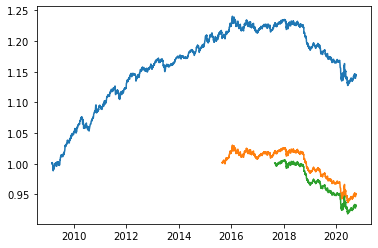

In [20]:
settings_ = [
            ('2009-01-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio'), 
            ('2015-09-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio'),
            ('2017-09-01', 0.12, 0.08, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')
           ]

result_ = {} 

for i, config in enumerate(settings_):
    print(config)
    result_[i] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            lower_bound=config[2],
                                            drop_strategy=config[3],
                                            target=config[4])

('2009-01-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2015-09-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2017-09-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
CPU times: user 1min 17s, sys: 409 ms, total: 1min 17s
Wall time: 31.3 s


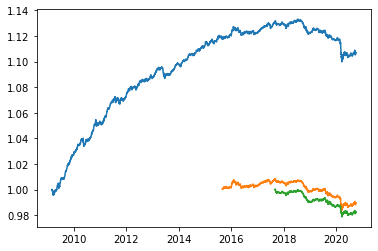

In [21]:
%%time
settings = [
            ('2009-01-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'), 
            ('2015-09-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'),
            ('2017-09-01', 1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
           ]

result = {} 

for i, config in enumerate(settings):
    print(config)
    result[i] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            lower_bound=config[2],
                                            drop_strategy=config[3],
                                            target=config[4])

In [22]:
print(result[0]['weights'].max() - 0.02, result[0]['weights'].max() + 0.02)

0.1688992459600711 0.2088992459600711


In [23]:
print(result[1]['weights'].max() - 0.02, result[1]['weights'].max() + 0.02)

0.3128764898610567 0.35287648986105674


In [24]:
print(result[2]['weights'].max() - 0.02, result[2]['weights'].max() + 0.02)

0.36646091165777195 0.406460911657772


In [5]:
from PortfolioPerformance import * 
return_compoent = result[config]['df_return'].set_index('Date').fillna(0)
weights = result[config]['weights'] 

/opt/anaconda3/lib/python3.8/site-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [7]:
start_date = return_compoent.index[0]
month_end_list = [start_date] + list(pd.date_range(start_date, '2020-10-07', freq='BM'))

In [8]:
strategy_list = list(return_compoent.columns[1:])
d = {strategy: weights[i] for i, strategy in enumerate(strategy_list)}
weight_component = pd.DataFrame(d, index=month_end_list)


In [14]:
# weight_component.columns

In [15]:
# return_compoent[weight_component.columns].columns

In [9]:
# %%time
# df_rebalanced_port = Get_Portfolio_Index(return_compoent[weight_component.columns], weight_component)

In [10]:
# plt.plot(df_rebalanced_port['portfolio_index']/1000)

In [11]:
# weight_component.tail()

In [12]:
# weight_component.head()

In [13]:
# return_compoent.tail()